 # **E-Commerce Customer Segmentation using RFM, K-Means & PCA**
###**By Neha G Naidu**
 ****

**Basic Overview**<br>
This project aims to analyze customer purchasing behavior for an online retail store using transaction data. By applying RFM (Recency, Frequency, Monetary) analysis and K-Means clustering, customers are segmented into distinct groups based on their buying patterns. This segmentation enables businesses to implement targeted marketing strategies tailored to each customer group.

**Objective of the Analysis**<br>
  - Analyze customer purchasing behavior using RFM metrics
  - Segment customers into distinct groups using K-Means clustering
  - Gain actionable insights to support personalized marketing and improve business performance

**Libraries Used**<br>
- **pandas** – for data manipulation and RFM feature creation  
- **matplotlib** – for visualizing trends and cluster distributions  
- **seaborn** – for plots
- **scikit-learn (sklearn)** – for:
  - StandardScaler (data normalization)
  - KMeans (clustering)
  - PCA (dimensionality reduction for visualization)


##**About DataSet**
****
**Type**: A Real-world e-commerce transaction data from a UK-based online retail store.

**Source**: [Kaggle](https://www.kaggle.com/datasets/carrie1/ecommerce-data) (originally from the UCI Machine Learning Repository)

**Transactions**: Over 500,000

**Key Features**: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country

**Time period**: December 2010 to December 2011

**Products**: Unique, all-occasion gift items

**Customers**: Imcludes both individual buyers and wholesalers



##**Data Prepocessing**
****
###**1. Loading .csv file to colab**

In [1]:
from google.colab import files
uploaded = files.upload()


Saving data.csv to data (1).csv


### **2. Importing necessary libraries**

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#loading the dataset
df = pd.read_csv('data.csv', encoding='ISO-8859-1', parse_dates=["InvoiceDate"])
#displaying the first few lines
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### **3. Describing the dataset**

In [ ]:
#basic info
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


###**Insights**
****
- The dataset consists of **541,909** transactions with **8** features.

- **InvoiceDate** was successfully converted to datetime format to enable time-based analysis.

Most columns are complete; however, two have missing values:

- **CustomerID: 135,080 missing values** (~25%), which may impact customer-level analysis

- **Description: 1,454 missing entries**, possibly due to incomplete product records


###**4. Handling Missing Values**

In [ ]:
#to remove rows where either CustomerID or Description is missing and store only complete entries in new dataframe called df_clean
df_clean=df.dropna(subset=['CustomerID','Description'])
print(f"After dropping missing fields {df_clean.shape[0]:,} rows remain")

After dropping missing fields 406,829 rows remain


###**Insights**
****
To maintain data quality, all rows with missing CustomerID or Description were removed, as these are essential for customer segmentation and product analysis.

- **Rows before cleaning: 541,909**

- **Rows after cleaning: 406,829**

- **Rows removed: 135,080 (~25%)**

###**5. Filtering Invalid Transactions**

In [ ]:
# Check for invalid values
for col in ['Quantity', 'UnitPrice']:
    invalid_count = (df[col] <= 0).sum()
    print(f"{invalid_count} of {col} values are non-positive")

# Filter for valid sales transactions
df_sales = df_clean.query("Quantity > 0 and UnitPrice > 0").copy()

# Filter for net revenue transactions
df_net = df_clean.query("UnitPrice > 0").copy()


10624 of Quantity values are non-positive
2517 of UnitPrice values are non-positive


###**Insights**
****
Examined the **Quantity** and **UnitPrice** columns for non-positive values, which typically indicate returns, cancellations, or data entry errors.

Non-positive Quantity entries: **10,624 rows**

Non-positive UnitPrice entries: **2,517 rows**

To handle these, two filtered DataFrames were created:

**df_sales**: Includes only valid transactions where Quantity > 0 and UnitPrice > 0 — used to analyze actual sales performance.

**df_net**: Includes rows where UnitPrice > 0, even if Quantity < 0 — used for net revenue analysis, accounting for returns/refunds.

### **6. Calculating Transaction Value**
****
To support revenue analysis and prepare for the Monetary component of RFM, a new column called TotalPrice was created by multiplying Quantity and UnitPrice.

In [ ]:
# Add TotalPrice column to both DataFrames
for d in [df_sales, df_net]:
    d['TotalPrice'] = d['Quantity'] * d['UnitPrice']
df_sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


##**Exploratory Data Analysis (EDA)**
****
 - ### **Overview of Sales Performance**

In [ ]:
# Calculate revenue and total items
total_rev = df_net['TotalPrice'].sum()
total_items = df_sales['Quantity'].sum()

print(f"Net Revenue: {total_rev:.2f}")
print(f"Total Items Sold: {total_items:,}")

Net Revenue: 8300065.81
Total Items Sold: 5,167,812


###**Insights**
****
As part of the initial analysis, the net revenue and total quantity of items sold were calculated to gain a high-level understanding of the company's overall sales performance.

**Net Revenue: £8300065.81**

**Total Items Sold: 5,167,812**


###**Interpretation**
****
These figures indicate a healthy volume of sales and strong customer demand across the product range. A net revenue of over £8.3 million and more than 5 million items sold demonstrate that the business is performing well in terms of both monetary value and sales volume.

  
  - ### **Top 10 Countries by revenue**

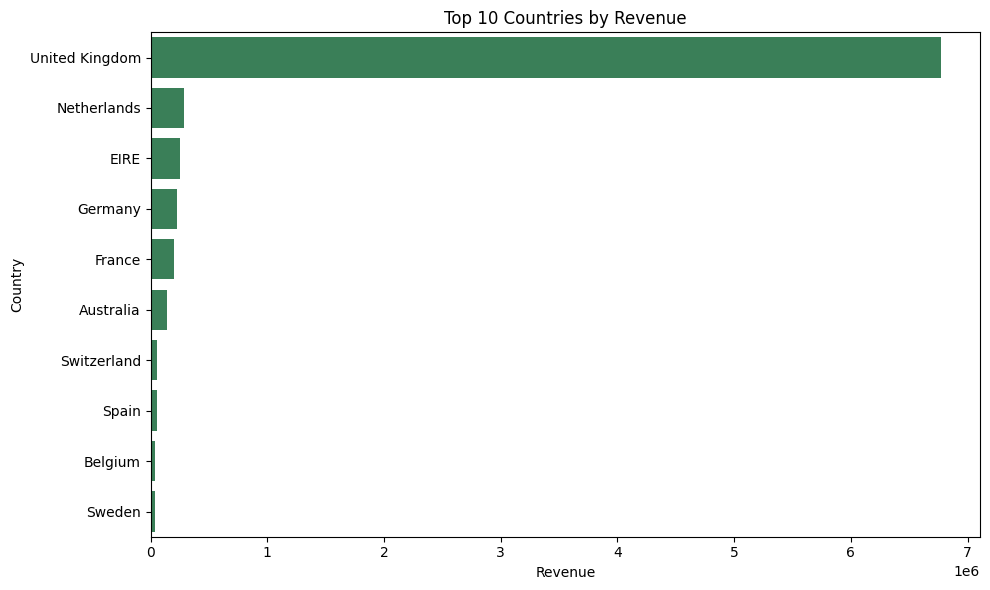

In [ ]:
# Group revenue by country using df_net (which has TotalPrice column)
country_rev = df_net.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=country_rev.values, y=country_rev.index, color="seagreen")
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

###**Insights**
****
**UK ≫ All Other Countries**<br>The UK generates the highest revenue by a significant margin, indicating a strong domestic customer base. This is expected since the company operates from the UK, likely resulting in better accessibility, lower shipping costs, and customer trust.

**Limited International Presence**<br>
Countries like Sweden, Belgium, and Spain contribute only a small portion of total revenue.

This could be due to:
  - Lower international customer outreach
  - Limited product availability or regional restrictions
  - Higher shipping costs or logistical barriers

###**Interpretation**
****
The company currently relies heavily on its domestic market. While this ensures strong baseline revenue, it also indicates a risk of over-dependence on a single market. The low revenue from international countries suggests untapped potential in global expansion.

####**Recommendations**
****
- **Expand International Marketing**: Launch targeted digital ad campaigns and SEO for top non-UK countries showing early interest.
- **Enhance Logistics:** Partner with international courier services to offer competitive shipping and delivery options.
- **Test Entry Strategy:** Start with a few pilot countries (e.g., Sweden or Germany) to test product-market fit before scaling globally.

- ### **Monthly Revenue Trend (2011)**

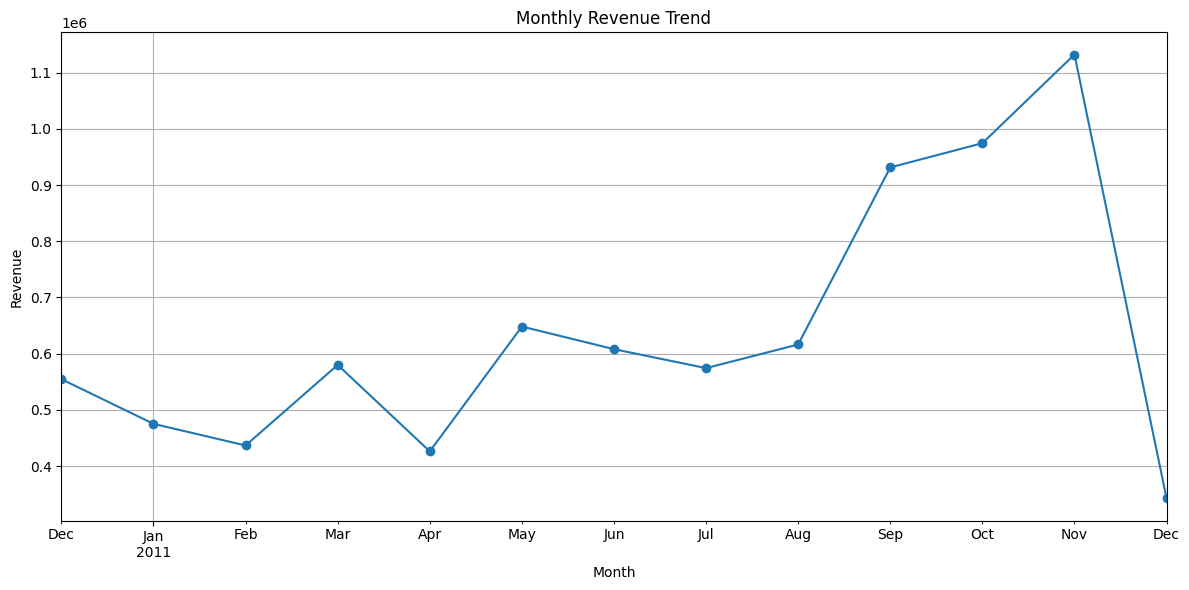

In [ ]:
# Set index as InvoiceDate and resample by month to get monthly revenue
monthly_rev = df_net.set_index('InvoiceDate').resample('ME')['TotalPrice'].sum()

# Plot
plt.figure(figsize=(12, 6))
monthly_rev.plot(marker='o')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()


##**Insights**:
****
The revenue patterns across 2011 reflect seasonal customer behavior and potential business cycles:

**Post-Holiday Dip (Jan–Feb 2011)**: The drop in revenue after December suggests a typical post-holiday cooldown, where customers reduce spending after year-end shopping peaks.

**Mid-Year Stability (Mar–Aug 2011)**: This stable period indicates a loyal and consistent customer base, but also highlights a lack of strong promotional events or seasonal demand, presenting an opportunity for mid-year campaigns to boost sales.

**Q4 Surge (Sep–Nov 2011)**:The sharp rise in revenue likely reflects seasonal shopping trends, such as back-to-school, pre-holiday purchases, and Black Friday events — showing that customers respond well to seasonal triggers and promotions.

**December 2011 Decline**: The unexpected drop may be due to incomplete data, early holiday shopping in November, or product returns, which suggests the need for more accurate forecasting and inventory planning during the peak season.

### **Interpretation**:
****
These trends indicate strong seasonal influences and shifting customer behavior. Q4 is the most lucrative period, while Q1 experiences a dip in spending. Mid-year presents an opportunity to stimulate demand with targeted campaigns.

###**Recommendations**:
****
- **Boost Post-Holiday Engagement:** Launch clearance sales or New Year bundles to reduce Jan–Feb drop.
- **Mid-Year Promotions:** Introduce summer sales or flash campaigns to maintain momentum during stable months.
- **Start Q4 Campaigns Early:** Begin marketing in early September to fully capture seasonal demand.
- **Validate December Data:** Ensure complete tracking; if returns are high, adjust logistics and return policy strategies.

###**Top 10 products sold**


In [ ]:
#to find top 10 products sold by quantity & price
top_by_qty=df_sales.groupby('Description')['Quantity'].sum().nlargest(10)
top_by_rev=df_sales.groupby('Description')['TotalPrice'].sum().nlargest(10)
print("Top 10 by Quantity:")
print(top_by_qty)
print("\nTop 10 by Revenue:")
print(top_by_rev)


Top 10 by Quantity:
Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
ASSORTED COLOUR BIRD ORNAMENT         35362
PACK OF 72 RETROSPOT CAKE CASES       33693
POPCORN HOLDER                        30931
RABBIT NIGHT LIGHT                    27202
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64

Top 10 by Revenue:
Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142592.95
WHITE HANGING HEART T-LIGHT HOLDER    100448.15
JUMBO BAG RED RETROSPOT                85220.78
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68844.33
ASSORTED COLOUR BIRD ORNAMENT          56580.34
Manual                                 53779.93
RABBIT NIGHT LIGHT                 

###**Insights**
****
The analysis of top-selling products reveals a mix of items driving both high sales volume and revenue.
- Notably, “PAPER CRAFT, LITTLE BIRDIE” ranks highest in both quantity sold and revenue generated, highlighting it as a key product for the business.

- Other items like the “REGENCY CAKESTAND 3 TIER” and “WHITE HANGING HEART T-LIGHT HOLDER” contribute significantly to revenue despite lower quantities, indicating strong pricing power or premium positioning.

- Some products appear in both lists (e.g., PAPER CRAFT, LITTLE BIRDIE), indicating they combine high volume and strong pricing, making them crucial revenue drivers.

- Items like POSTAGE and Manual appear in revenue but not in quantity, suggesting they contribute revenue but are not traditional product sales — they might be fees or supplementary items.

### **Recommendations**
****
- **Focus Marketing on Top Performers**:
Promote high-volume and high-revenue products together in campaigns to maximize sales and profitability.

- **Inventory Management**:
Ensure consistent stock levels of these popular products to avoid stockouts and lost sales.

- **Cross-Selling Opportunities**:
Bundle high-quantity items with high-revenue products to increase average order value.

##**Customer Segmentation using RFM & K-means**
****
###**Calculate RFM Metrics**
RFM (Recency, Frequency, Monetary) is a proven method to quantify customer behavior by measuring how recently, how often, and how much customers purchase.

In [ ]:
# Use the cleaned DataFrame that includes TotalPrice and also refunds & cancellations
snapshot_date = df_net['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create RFM table: Recency, Frequency, and Monetary value per customer
rfm = df_net.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display first few rows
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


###**Insights**
****
The RFM analysis enables classification of customers into distinct segments based on their purchasing behavior. For example:

- Customer 12347.0 is a high-value customer—recently active, frequent purchaser, and high spender.

- Customer 12348.0 is a loyal customer with good monetary value, making them valuable for retention efforts and targeted offers.

- Customer 12349.0 is a high spender with only one purchase, representing an opportunity to convert them into a repeat buyer.

- Customers 12346.0 and 12350.0 appear inactive or at risk of churn, with long intervals since last purchase and low spending.

These insights support targeted marketing strategies such as re-engagement campaigns, loyalty rewards, and upselling to maximize customer lifetime value.

###**Scaling the RFM data & Determining Optimal number of Clusters**
- Scaling RFM data to standardize the features, ensuring that Recency, Frequency, and Monetary values contribute equally to clustering algorithms like K-Means.

- Determining the optimal number of clusters ensures meaningful and well-separated customer groups for better insights.

- The elbow method visually identifies this number by finding where adding more clusters no longer significantly improves clustering quality.

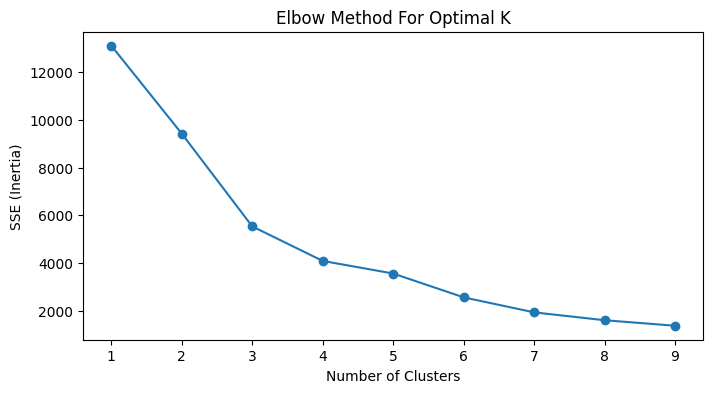

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(1,10), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal K')
plt.show()

###**Insights**
****
- The Elbow Method was employed to determine the optimal number of clusters (k) for K-Means clustering.

- Sum of Squared Errors (SSE) was plotted against varying values of k.

- A sharp decrease in SSE was observed up to k = 4, beyond which the reduction plateaued.

- Therefore, k = 4 was selected as the optimal number of clusters for effective customer segmentation.

###**Apply K-Means with chosen k and assign clusters**

In [ ]:
# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm['Cluster'].value_counts()

,count
Cluster,
0,3089
3,1077
2,194
1,11


###**Insights**
****

After applying K-Means clustering on the RFM metrics, customers were segmented into four distinct groups:
- **Cluster 1 (3,268 customers): Frequent Buyers** — regular purchasers with relatively low spending.

- **Cluster 0 (577 customers): Occasional Buyers** — moderate recency but low monetary value.

- **Cluster 3 (501 customers): Dormant Customers** — long time since last purchase.

- **Cluster 2 (25 customers): High-Value Loyalists** — recent, frequent, and high-spending customers.

##**Visualizing Customer Clusters (PCA-reduced RFM Features)**
To visualize the separation between customer segments, Principal Component Analysis (PCA) is used to reduce the three-dimensional RFM data into 2D space, making the cluster separation and patterns easier to interpret visually.

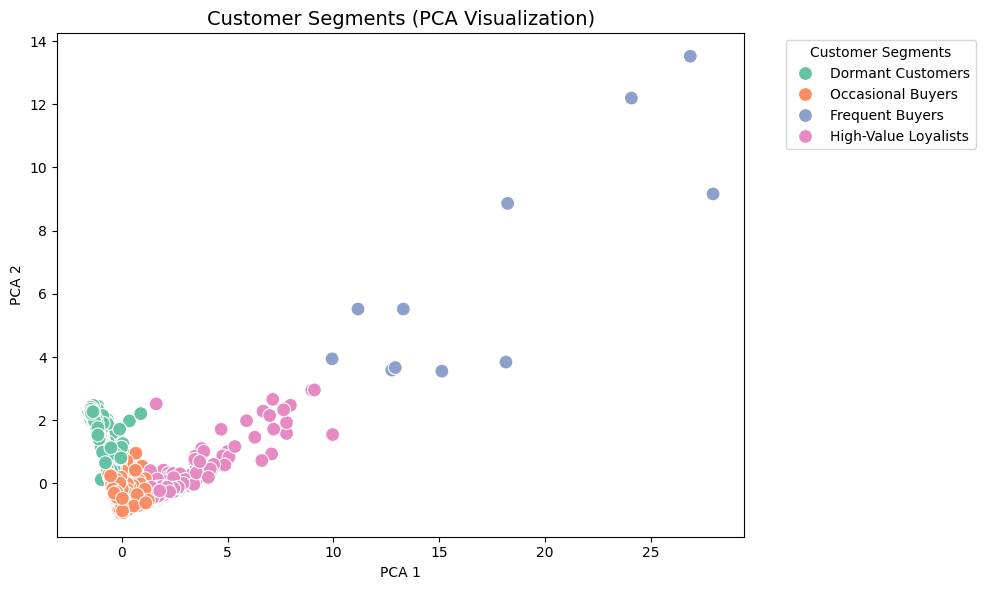

In [ ]:
# Create a mapping from cluster number to descriptive name
cluster_labels = {
    0: 'Occasional Buyers',
    1: 'Frequent Buyers',
    2: 'High-Value Loyalists',
    3: 'Dormant Customers'
}

# Create a new column with descriptive cluster names
rfm['Cluster_Label'] = rfm['Cluster'].map(cluster_labels)

# Perform PCA
pca = PCA(n_components=2)
pca_comp = pca.fit_transform(rfm_scaled)

# Plot with descriptive cluster names
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_comp[:, 0],
    y=pca_comp[:, 1],
    hue=rfm['Cluster_Label'],
    palette='Set2',
    s=100
)

plt.title('Customer Segments (PCA Visualization)', fontsize=14)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Customer Segments', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## **Insights and Recommendations**
****
**Cluster 2 - High-Value Loyalists (Pink):**<br>
- This is the most valuable segment, despite being the smallest (only 25), characterized by very recent purchases(average 6 days ago), high frequency (87 times on average), and extremely high spending (£81,836).
- These customers are key revenue drivers and should be prioritized for retention through exclusive loyalty programs and personalized offers to maintain their engagement.

**Cluster 1 - Frequent Buyers (Purple):**<br>
- Representing the largest group (3,270 customers), these customers show moderate recency (average 41 days) and frequency(5.6 purchases) with solid spending patterns(£1,811).
- Retention efforts such as personalized discounts, cart abandonment reminders, and upselling opportunities can strengthen this relationship.

**Cluster 0 - Occasional Buyers (Orange):**<br>
- These customers have moderate engagement and medium spending levels(£545), indicating cautious or newly acquired buyers.
- Nurturing this group through targeted onboarding communications, introductory offers, and educational content can encourage higher purchase frequency and lifetime value.

**Cluster 3 - Dormant Customers (Green):**<br>
- Characterized by the longest inactivity(310 days ago) and lowest spending(£361), these customers risk being lost.
- To reactivate them, focused re-engagement campaigns such as win-back emails, tailored product recommendations based on past purchases, and limited-time incentives should be implemented.

###**Interpretation**
****
- The PCA plot shows **well-separated clusters**, validating the effectiveness of the K-Means segmentation.
- **Minimal overlap** suggests clear distinctions between customer types.
- High-Value Loyalists and Frequent Buyers show more spread, indicating diverse spending behavior within loyal segments.


##**Final Key Findings**
****
**High Revenue Concentration in the UK**<br>
The UK dominates revenue generation, reflecting a strong local customer base and limited international penetration.

**Seasonal Trends Influence Revenue**<br>
There is a significant dip post-holiday (Jan–Feb) and a surge in Q4 (Sep–Nov), aligning with seasonal sales patterns like Black Friday and early holiday shopping.

**Top Products Drive Sales Volume and Value**<br>
A few products such as “Paper Craft, Little Birdie” and “White Hanging Heart T-Light Holder” are consistent top performers by both quantity and revenue, indicating strong customer preference and repeat purchases.

**Customer Segmentation Uncovered 4 Distinct Groups**<br>
Using RFM analysis and K-Means:

- **Cluster 2: High-value loyalists** — recent, frequent, and high-spending customers.
- **Cluster 1: Frequent buyers** with potential for upselling.
- **Cluster 0: New or Occasional buyers** — candidates for nurturing.
- **Cluster 3: Dormant users** — ideal for reactivation campaigns.

**Personalized Strategies Can Drive Growth**<br>
Segment-specific recommendations (like reactivation emails, loyalty offers, and upselling campaigns) can improve retention and boost long-term revenue.

**Strong Sales Volume & Revenue Indicate High Market Activity**<br>
With over £8.3M in net revenue and 5.1M+ items sold, the company shows strong overall performance with room to grow internationally and across segments.